In [1]:
# Computational Physics Project 4 - Molecular Orbital Theory
# Ben Zager, Zach Faber-Manning, Michael Rosen

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.linalg import eigh,solve


In [2]:
# Constants

# adjacency matrix of carbons
buta = np.array([[0,1,0,0],[1,0,1,0],[0,1,0,1],[0,0,1,0]]) # butadiene (N=4)
benz = np.array([[0,1,0,0,0,1],[1,0,1,0,0,0],[0,1,0,1,0,0],[0,0,1,0,1,0],[0,0,0,1,0,1],[1,0,0,0,1,0]]) # benzene (N=6)
ethy = np.array([[0,1],[1,0]]) # ethylene (N=2)

adj = buta # select which molecule

N = adj.shape[0] # number of carbons
Ne = N # number of electrons


In [3]:
# Compute eigenvalues and eigenvectors

# Finds eigenvalues and eigenvectors
# args: adjacency matrix
# rets: tuple, (eigenvalues,eigenvectors) 
def getEigs(adj):
    eigs = eigh(adj)
    evals = np.flip(np.around(eigs[0],4),0) # eigenvalues
    evecs = np.flip(np.around(eigs[1],4),1) # eigenvectors
    
    return (evals,evecs)

evals,evecs = getEigs(adj)

print("Eigenvalues\n")
for i in range(N):
    print(str(i+1)+" : a + "+str(np.around(evals[i],3))+"b  " + str(np.around(evecs[:,i],3)))


Eigenvalues

1 : a + 2.0b  [-0.408 -0.408 -0.408 -0.408 -0.408 -0.408]
2 : a + 1.0b  [ 0.577  0.289 -0.289 -0.577 -0.289  0.289]
3 : a + 1.0b  [ 0.  -0.5 -0.5  0.   0.5  0.5]
4 : a + -1.0b  [ 0.   0.5 -0.5  0.   0.5 -0.5]
5 : a + -1.0b  [ 0.577 -0.289 -0.289  0.577 -0.289 -0.289]
6 : a + -2.0b  [ 0.408 -0.408  0.408 -0.408  0.408 -0.408]


(array([-2., -1.,  1.,  2.]), array([1, 2, 2, 1]))


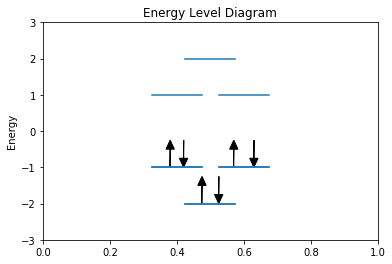

[-2. -2. -1. -1. -1. -1.]
[ 2.  2.  2.  0.  0.  0.]
-8.0


In [56]:
# Very ugly function, try to improve

# Plots energy level diagram and determines electron energies
# args: ordered list of eigenvalues, number of electrons
# rets: list of energies for the Ne electrons
def energyLevel(evals,Ne,show=True):
    
    # parameters for drawing diagram
    mid = 0.5 # midpoint
    width = 0.15 # width of each line
    space = 0.05 # spacing between lines
    arrlen = 0.5 # arrow length
    hw = 0.025 # width of head of arrow
    hl = 0.25 # length of head of arrow

    # get unique list of energies
    # returns tuple of two arrays, ([energies],[multiplicity])
    uniq = np.unique(np.around(evals,4),return_counts=True)

    energies = np.zeros(Ne) # stores energies of each electron
    occu = np.zeros(N) # occupation number
    filled = 0 # keep track of how many electrons are left
    orb = 1 # keep track of current orbital

    print(uniq)
    
    for i in range(uniq[0].size): # go through each unique energy level
        E = uniq[0][i]
        m = uniq[1][i] # multiplicity
        start = mid - 0.5*(m-1)*(width+space) # where first line is drawn (left edge)
        
        turn = 1 # 1st or 2nd sweep through level
        j = 0 # keep track of degenerate energy levels
        
        while j < m:
            xL = start + j*(width+space) - 0.5*width # set bounds for drawing line
            xR = xL + width
            plt.axhline(E,xmin=xL,xmax=xR)
            
            if filled < Ne: 
                energies[filled] = E
                
                if turn == 1:
                    elec = 0.95*np.mean([xL,xR])
                    plt.arrow(elec,E,0,arrlen,head_width=hw,head_length=hl,fc='k',ec='k')
                    filled += 1
                    occu[orb-1] = 1 # set occupation number to 1
                    
                    if j == m-1:
                        turn = 2
                        j = 0
                        orb -= (m-1)
                        continue
                        
                elif turn == 2:
                    elec = 1.05*np.mean([xL,xR])
                    plt.arrow(elec,E+arrlen+hl,0,-arrlen,head_width=0.025,head_length=0.25,fc='k',ec='k')
                    filled += 1
                    occu[orb-1] = 2
                orb += 1
            j += 1
    
    plt.ylabel("Energy")
    plt.xlim([0,1])
    plt.ylim([np.min(evals)-1,np.max(evals)+1])
    plt.title("Energy Level Diagram")
    if show:
        plt.show()
        
    return energies,occu


energies,occu = energyLevel(evals,Ne)
print(energies); print(occu);
ETot = np.sum(energies)
print(ETot)


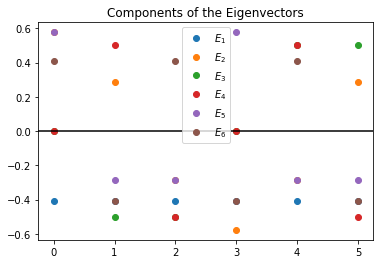

In [10]:
# Plot eigenvectors

for i in range(N):
    plt.plot(evecs[:,i],'o',label=r"$E_"+str(i+1)+"$")

plt.axhline(0,color='k')
plt.title("Components of the Eigenvectors")
plt.legend()
plt.show()

In [6]:
# Delocalization energy of butadiene
# energy difference from ground state and isolated double bonds (compare to ethylene)
# 

# determine delocalization energy, given total ground state energy and number of double bonds
def calcDeloc(E,numDB):
    Ne_ethy = 2
    evals_ethy = getEigs(ethy)[0]
    E_ethy = energyLevel(evals_ethy,Ne_ethy,show=False)
    ETot_ethy = np.sum(E_ethy)
    deloc = numDB*ETot_ethy - ETot

    return deloc

numDB = 2 # number of double bonds
deloc = calcDeloc(ETot,numDB)

print(str(deloc)+"b")

4.0b


In [7]:
# Charge density estimation 
# for single electron in orbital I, |c_Ir|^2 is probability of electron being on atom r

def chargeDensity(r,evecs,energies):
    c = evecs[:,r] # get the rth component of eigenvector
    cSqr = np.square(c) # 
    v = np.zeros(N) # 
    
    for I in xrange(N):
        v[I] = 
    
    q = np.sum(np.product(cSqr,v))
    return q

q = np.zeros(N)

for r in xrange(N):
    q[r] = chargeDensity(r,evecs,energies)


SyntaxError: invalid syntax (<ipython-input-7-c9ce0aeb07ad>, line 10)

In [43]:
# Bond order calculation
print(evecs)


[[-0.4082  0.5774  0.      0.      0.5774  0.4082]
 [-0.4082  0.2887 -0.5     0.5    -0.2887 -0.4082]
 [-0.4082 -0.2887 -0.5    -0.5    -0.2887  0.4082]
 [-0.4082 -0.5774  0.      0.      0.5774 -0.4082]
 [-0.4082 -0.2887  0.5     0.5    -0.2887  0.4082]
 [-0.4082  0.2887  0.5    -0.5    -0.2887 -0.4082]]
